In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# 머신러닝에 사용할 알고리즘
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
# 필요한 평가 지표 모듈 가져오기
from sklearn.metrics import classification_report, f1_score, accuracy_score,precision_score, confusion_matrix,plot_confusion_matrix,roc_auc_score,recall_score,roc_curve

In [ ]:
path = ('/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model ')

In [ ]:
train_x = np.load( '/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/train_x.npy',allow_pickle=True)
train_y = np.load( '/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/train_y.npy',allow_pickle=True)
test_x = np.load( '/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/test_x.npy',allow_pickle=True)
test_y = np.load( '/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/test_y.npy',allow_pickle=True)
train_x, test_x, train_y, test_y

(array([[    0,     0,     0, ...,     2,  4624,  8380],
        [    0,     0,     0, ...,     2,  4974,  3416],
        [    0,     0,     0, ...,  3487, 25167, 10019],
        ...,
        [    0,     0,     0, ...,     2,  1721,  1363],
        [    0,     0,     0, ...,   753,    79,    13],
        [    0,     0,     0, ...,    51,    21,   831]], dtype=int32),
 array([[   0,    0,    0, ..., 1253, 6556, 6557],
        [   0,    0,    0, ...,  403,  743,  344],
        [   0,    0,    0, ...,    0,    0, 6224],
        ...,
        [   0,    0,    0, ...,    2,  465, 1050],
        [   0,    0,    0, ...,  447,  246, 7405],
        [   0,    0,    0, ...,    2,  598, 1090]], dtype=int32),
 array([0, 0, 1, ..., 0, 1, 1]),
 array([0, 0, 1, ..., 0, 1, 0]))

In [ ]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((20800, 30), (5200, 30), (20800,), (5200,))

In [ ]:
# 최적  알고리즘 테스트 및 찾기
def clacf(train_x,train_y,test_x,test_y) :
  als = {
      'KNeighborsClassifier'        :('--', KNeighborsClassifier() ),
      'SVC'                         :('--', SVC() ),
      'BernoulliNB'                  :('--', BernoulliNB() ),
      'RandomForestClassifier'      :('--', RandomForestClassifier() ),
      'XGBoostClassifier'          :('--', XGBClassifier() ),
      'AdaBoostClassifier'          :('--', AdaBoostClassifier() ),
      'LGBMClassifier'          :('--', LGBMClassifier() ),     
      'SGDClassifier'          :('--', SGDClassifier() ),
      
  }
  top_level_acc  = 0
  top_level_name = None
  for name, ( lineStyle, model ) in als.items(): 
    model.fit( train_x, train_y )
    pred = model.predict( test_x ) 
    #print( name, lineStyle, model )
    cur_acc = accuracy_score( test_y, pred )
    if cur_acc > top_level_acc :
      top_level_acc  = cur_acc
      top_level_name = [ name, classification_report( test_y, pred ) ]

  print( '최대 정확도 :', top_level_acc, top_level_name[0] ) 
  print('AUC Score :', roc_auc_score(test_y, pred))
  print( top_level_name[1] )

In [ ]:
clacf(train_x,train_y,test_x,test_y)

최대 정확도 : 0.8815384615384615 LGBMClassifier
AUC Score : 0.5910792020849756
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2572
           1       0.86      0.91      0.89      2628

    accuracy                           0.88      5200
   macro avg       0.88      0.88      0.88      5200
weighted avg       0.88      0.88      0.88      5200



# 각 알고리즘 파라미터 향상 및 모델 저장

In [ ]:
# 기본 모델링 함수 (먼저 하이퍼파라미터 튜닝 없이 모델을 학습하고 성능을 평가하는 함수)
def modeling_uncustomized1 (algorithm,  train_x, train_y, test_x, test_y):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm()
    uncustomized.fit(train_x, train_y)
    ypred = uncustomized.predict( test_x ) 

    # Test Data 설명력
    algorithm_acc = accuracy_score(test_y, ypred).round(3)
    print(f"파라미터 변경 전 정확도: {algorithm_acc}")
    return  algorithm_acc

In [ ]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.xlabel(xlabel) # x축
    plt.yticks([0,1])


In [ ]:
# 모델 최적화 함수: 학습할 트리 모델 개수 선정
def optimi_estimator(algorithm, algorithm_name, train_x, train_y, test_x, test_y, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=0)
        model.fit(train_x, train_y)
        train_score.append(model.score(train_x, train_y))
        test_score.append(model.score(test_x, test_y))
    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator")
    print(round(df_score_n, 4))

In [ ]:
# 모델 최적화 함수: 최대 깊이 선정
def optimi_maxdepth (algorithm, algorithm_name, train_x, train_y, test_x, test_y, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
      model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=0)
        
      model.fit(train_x, train_y)
      train_score.append(model.score(train_x, train_y))
      test_score.append(model.score(test_x, test_y))
    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth")
    print(round(df_score_n, 4))

In [ ]:
# 모델 최적화 함수: 분리 노드의 최소 자료 수 선정
def optimi_minsplit (algorithm, algorithm_name, train_x, train_y, test_x, test_y, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
      model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 0)
      model.fit(train_x, train_y)
      train_score.append(model.score(train_x, train_y))
      test_score.append(model.score(test_x, test_y))
    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node")
    print(round(df_score_n, 4))

In [ ]:
# 모델 최적화 함수: 잎사귀 노드의 최소 자료 수 선정
def optimi_minleaf(algorithm, algorithm_name,train_x, train_y, test_x, test_y, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
      model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=0)
      model.fit(train_x, train_y)
      train_score.append(model.score(train_x, train_y))
      test_score.append(model.score(test_x, test_y))
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node")
    print(round(df_score_n, 4))

In [ ]:
def show_metrics(y_pred, y_actual) :
  print('Accuracy  :',  accuracy_score(y_pred, y_actual))
  print('Precision :', precision_score(y_pred, y_actual))
  print('Recall    :',    recall_score(y_pred, y_actual))
  print('F1-score  :',        f1_score(y_pred, y_actual))
  print('Auc       :',   roc_auc_score(y_pred, y_actual))

In [ ]:
def show_roc_curve(y_pred, y_actual, path, model_name) :

  fig = plt.figure(figsize = (10, 8))
  FPR, TPR, n = roc_curve(y_actual, y_pred)
  
  plt.plot(FPR, TPR)
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  
  plt.title(model_name + ' ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.savefig(path + model_name + '_ROC_curve.png', dpi = 300)
  plt.show()

In [ ]:
def show_confusion_matrix(y_pred, y_actual, path, model_name) :
  fig = plt.figure(figsize = (10, 8))
  plt.title(model_name + ' Confusion Matrix')
  # annot : cell에 숫자 표현 유무, fmt : 숫자 형태(d : 정수)
  # cmap : color, cbar : color bar 유무
  sns.heatmap(confusion_matrix(y_pred, y_actual), annot = True, fmt = 'd', 
              cbar = False, cmap = sns.color_palette("Purples",2),
              xticklabels = ['Positive', 'Negative'],
              yticklabels = ['Positive', 'Negative'])
  plt.xlabel('Actuals')
  plt.ylabel('Predicted')
  plt.savefig(path + model_name +'_confusion_matrix.png', dpi = 300)
  plt.show()

In [ ]:
# 최종 모델 학습
def model_final(algorithm, algorithm_name,  train_x, train_y, test_x, test_y, n_estimator, n_depth, n_split, n_leaf):
  model = algorithm(random_state = 0, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
  # 모델 학습
  model.fit(train_x, train_y)
  # 최종 모델의 성능 평가
  train_acc = model.score(train_x, train_y)
  test_acc = model.score(test_x, test_y)
  y_pred = model.predict(test_x)
  show_metrics(y_pred, test_y)
  show_confusion_matrix(y_pred, test_y, path, 'RandomForest_2')
  show_roc_curve(y_pred, test_y, path, 'RandomForest_2')

# 검사
- 랜덤포레스트 하이퍼 파라미터 튜닝


In [ ]:
modeling_uncustomized1(RFC  ,  train_x, train_y, test_x, test_y)

파라미터 변경 전 정확도: 0.86


0.86

In [ ]:
algorithm = RFC
algorithm_name = 'rfc'

    n_estimators  TrainScore  TestScore
0              5      0.9784     0.8275
1             10      0.9908     0.8421
2             15      0.9938     0.8477
3             20      0.9958     0.8508
4             25      0.9967     0.8510
5             30      0.9968     0.8535
6             35      0.9971     0.8540
7             40      0.9973     0.8535
8             45      0.9974     0.8560
9             50      0.9976     0.8562
10            55      0.9978     0.8563
11            60      0.9978     0.8590
12            65      0.9979     0.8583
13            70      0.9979     0.8581
14            75      0.9979     0.8577
15            80      0.9980     0.8571
16            85      0.9980     0.8585
17            90      0.9980     0.8585
18            95      0.9981     0.8583
19           100      0.9981     0.8592
20           105      0.9981     0.8588
21           110      0.9981     0.8592
22           115      0.9981     0.8585
23           120      0.9981     0.8596


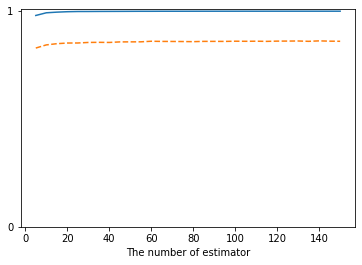

In [ ]:
# n_estimator  최적의 파라미터 
n_estimator_min= 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, train_x, train_y, test_x, test_y, n_estimator_min, n_estimator_max)

    depth  TrainScore  TestScore
0      20      0.9811     0.8598
1      21      0.9868     0.8588
2      22      0.9916     0.8573
3      23      0.9948     0.8596
4      24      0.9964     0.8587
5      25      0.9972     0.8569
6      26      0.9975     0.8577
7      27      0.9978     0.8563
8      28      0.9980     0.8587
9      29      0.9980     0.8604
10     30      0.9980     0.8596
11     31      0.9981     0.8617
12     32      0.9981     0.8592
13     33      0.9981     0.8592
14     34      0.9980     0.8619
15     35      0.9981     0.8596
16     36      0.9981     0.8577
17     37      0.9981     0.8585
18     38      0.9981     0.8585
19     39      0.9981     0.8581


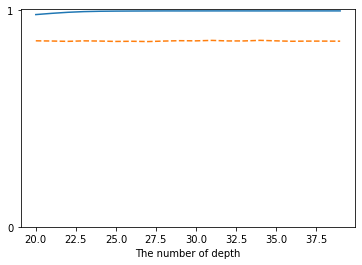

In [ ]:
# 최적의 depth
depth_min = 20
depth_max = 40
n_estimator = 95
optimi_maxdepth (algorithm, algorithm_name, 
                 train_x, train_y, test_x, test_y, depth_min, depth_max, n_estimator)

   min_samples_split  TrainScore  TestScore
0                  2      0.9981     0.8617
1                  4      0.9935     0.8562
2                  6      0.9801     0.8606
3                  8      0.9699     0.8608
4                 10      0.9591     0.8615
5                 12      0.9500     0.8587
6                 14      0.9437     0.8600
7                 16      0.9402     0.8569
8                 18      0.9333     0.8592


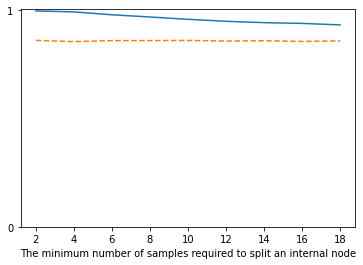

In [ ]:
# 최적의 split
n_split_min = 1
n_split_max = 10
n_depth = 31
optimi_minsplit (algorithm, algorithm_name, train_x, train_y, test_x, test_y,
                 n_split_min, n_split_max, n_estimator, n_depth)

   min_samples_leaf  TrainScore  TestScore
0                 2      0.9711     0.8596
1                 4      0.9365     0.8579
2                 6      0.9178     0.8562
3                 8      0.9061     0.8527


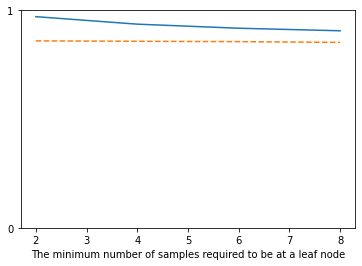

In [ ]:
# 최적의 leaf
n_leaf_min = 1
n_leaf_max = 5
n_split = 4
optimi_minleaf(algorithm, algorithm_name,train_x, train_y, test_x, test_y, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

Accuracy  : 0.8596153846153847
Precision : 0.9121004566210046
Recall    : 0.8276933701657458
F1-score  : 0.8678493845039827
Auc       : 0.8637164767495396


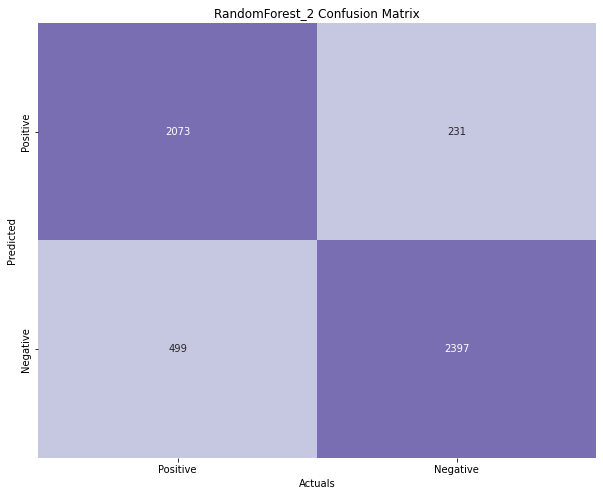

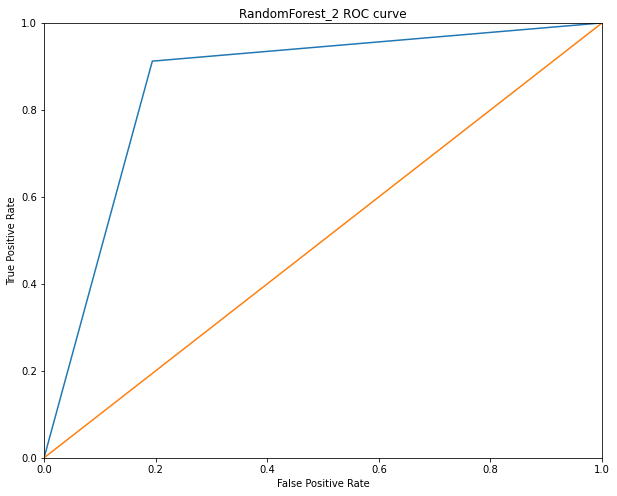

In [ ]:
# 최종 하이퍼 파라미터 조정 후 모델
n_leaf =2
model_final(algorithm, algorithm_name,  train_x, train_y, test_x, test_y, n_estimator, n_depth, n_split, n_leaf)

# 공통알고리즘 함수

In [ ]:
def algorithm(type) :
  algorithm_name = type()
  algorithm_name.fit(train_x , train_y)
  y_pred = algorithm_name.predict(test_x)
  show_metrics(y_pred, test_y)
  show_confusion_matrix(y_pred, test_y, path, 'algorithm_name')
  show_roc_curve(y_pred, test_y, path, 'algorithm_name')

Accuracy  : 0.6851923076923077
Precision : 0.580289193302892
Recall    : 0.7406508013598835
F1-score  : 0.6507360785150417
Auc       : 0.6947443755287159


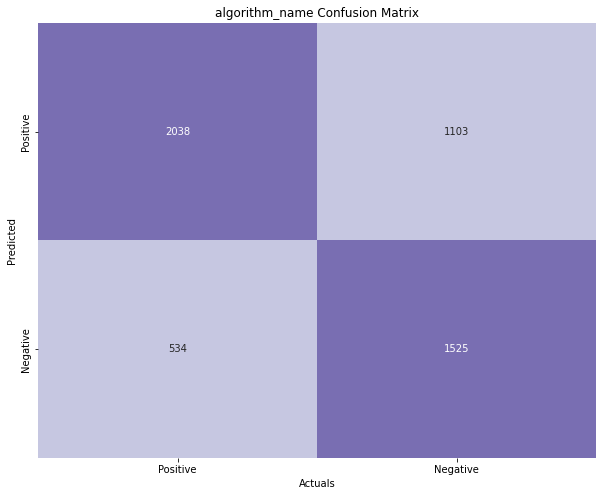

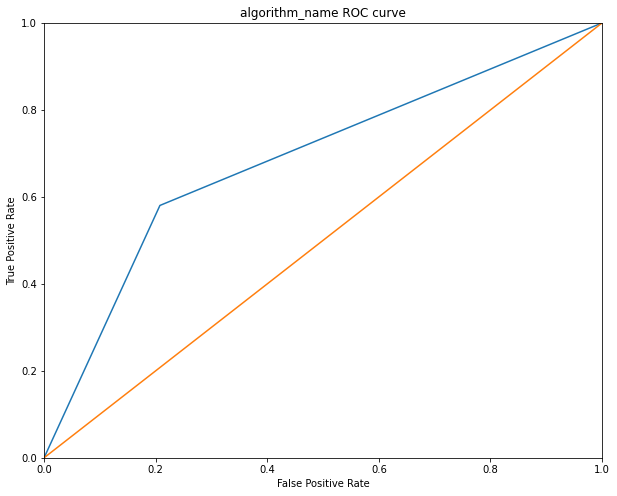

In [ ]:
# BernoulliNB
algorithm(BernoulliNB)

Accuracy  : 0.7213461538461539
Precision : 0.723744292237443
Recall    : 0.7245714285714285
F1-score  : 0.7241576242147345
Auc       : 0.7213148404993065


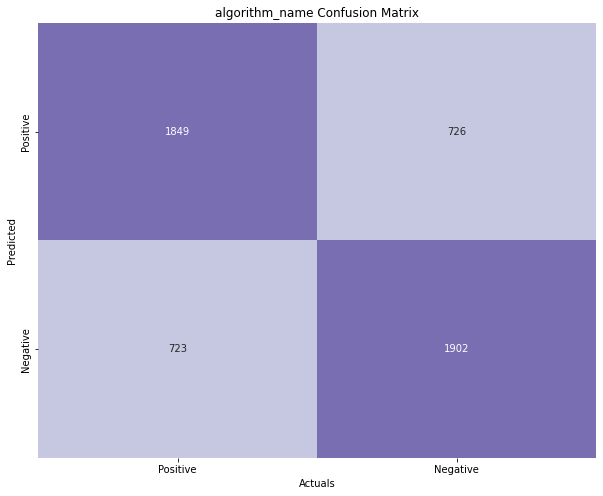

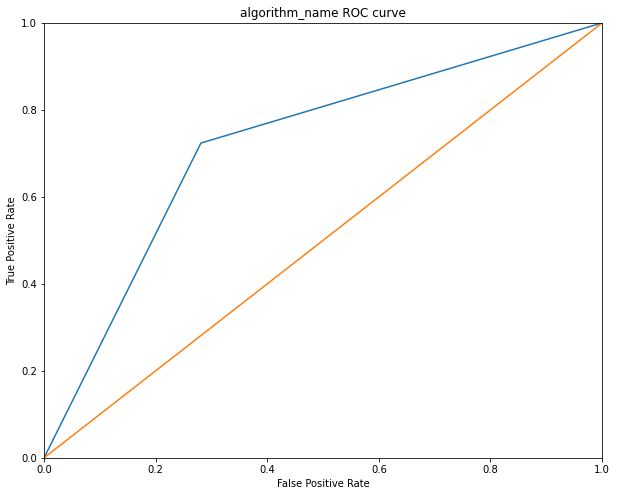

In [ ]:
# KNeighborsClassifier
algorithm(KNeighborsClassifier)

Accuracy  : 0.8246153846153846
Precision : 0.89117199391172
Recall    : 0.7890835579514824
F1-score  : 0.8370264474624731
Auc       : 0.8304736786173184


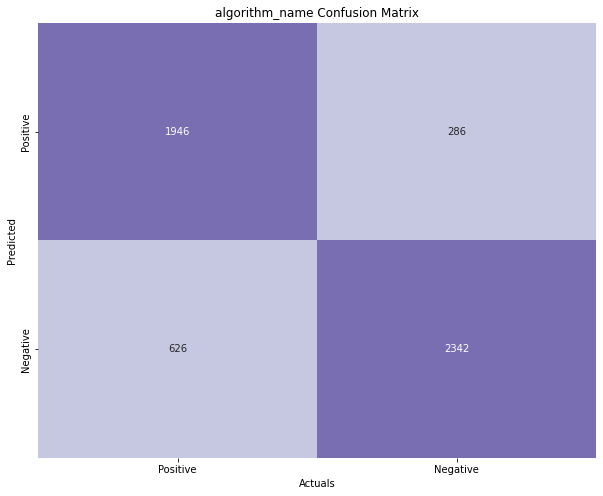

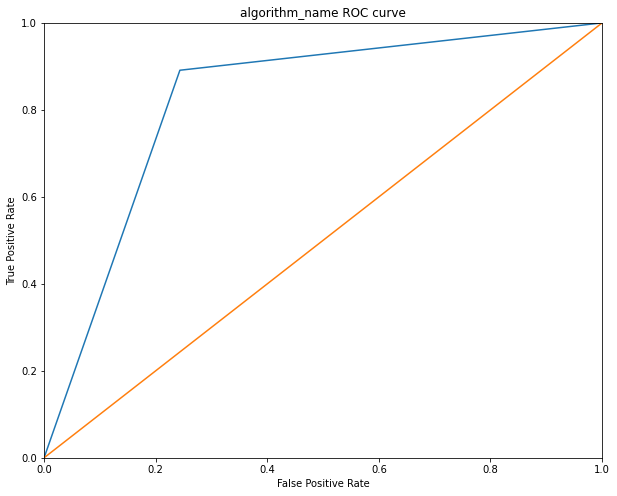

In [ ]:
# AdaBoostClassifier
algorithm(AdaBoostClassifier)

Accuracy  : 0.6434615384615384
Precision : 0.802130898021309
Recall    : 0.6124346310284718
F1-score  : 0.6945634266886326
Auc       : 0.6583219799055896


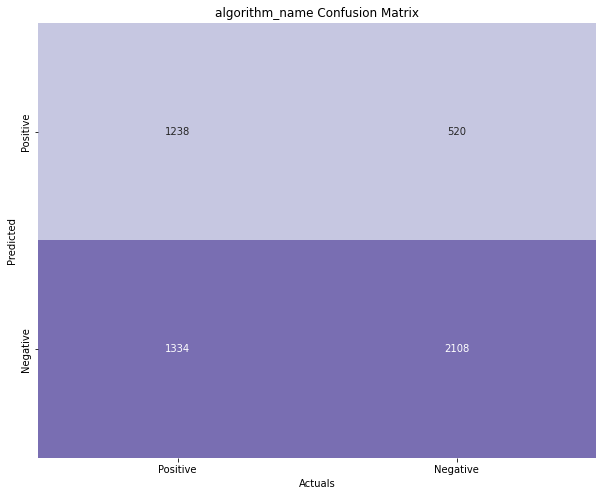

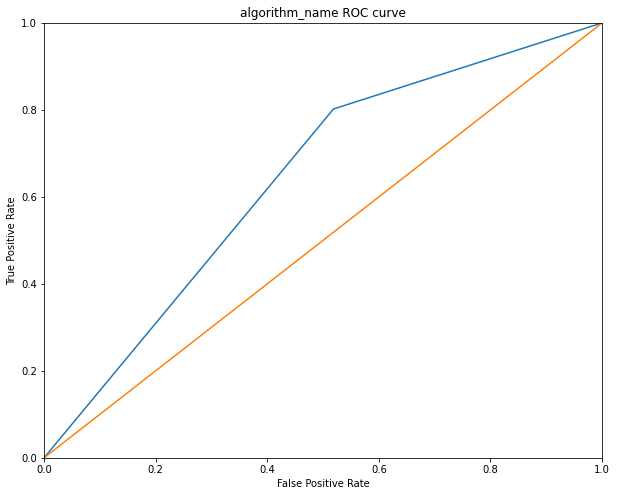

In [ ]:
# SGDClassifier
algorithm(SGDClassifier)

Accuracy  : 0.8607692307692307
Precision : 0.906392694063927
Recall    : 0.8328671328671329
F1-score  : 0.8680758017492712
Auc       : 0.863869463869464


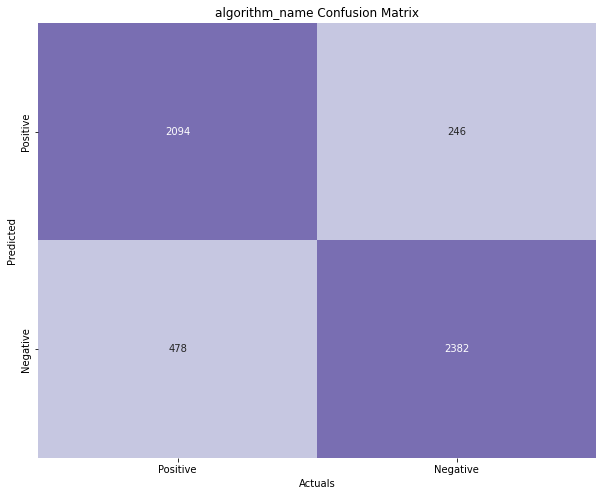

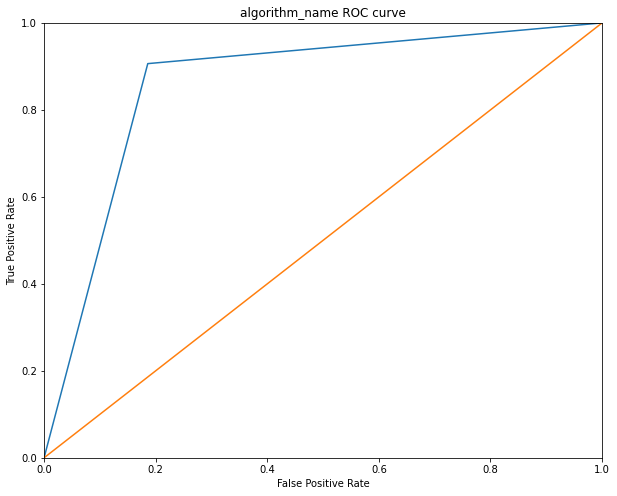

In [ ]:
# XGBClassifier
algorithm(XGBClassifier)

Accuracy  : 0.8815384615384615
Precision : 0.9140030441400304
Recall    : 0.8603151862464183
F1-score  : 0.8863468634686347
Auc       : 0.8832306828242058


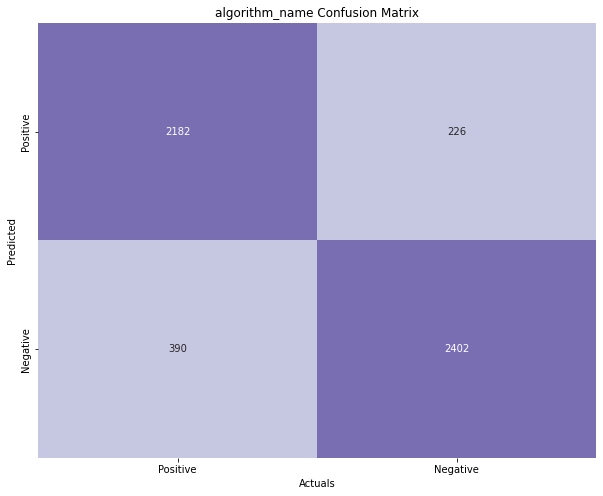

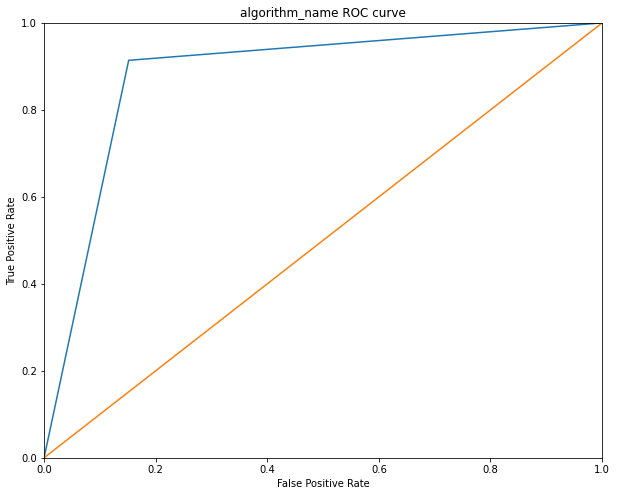

In [ ]:
# LGBMClassifier
algorithm(LGBMClassifier)

Accuracy  : 0.7332692307692308
Precision : 0.8017503805175038
Recall    : 0.708711738984191
F1-score  : 0.7523656489912516
Auc       : 0.7373823625320596


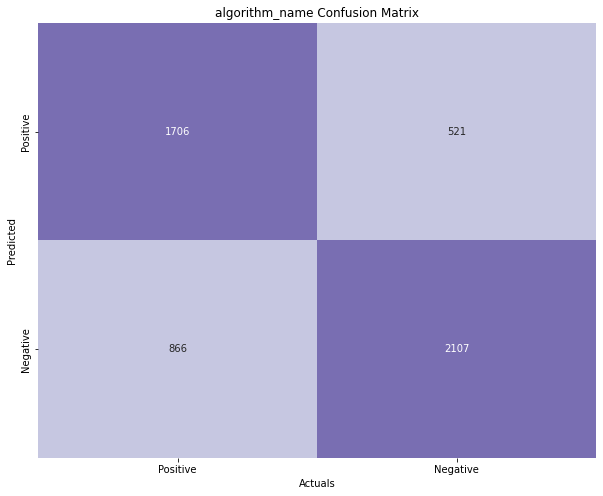

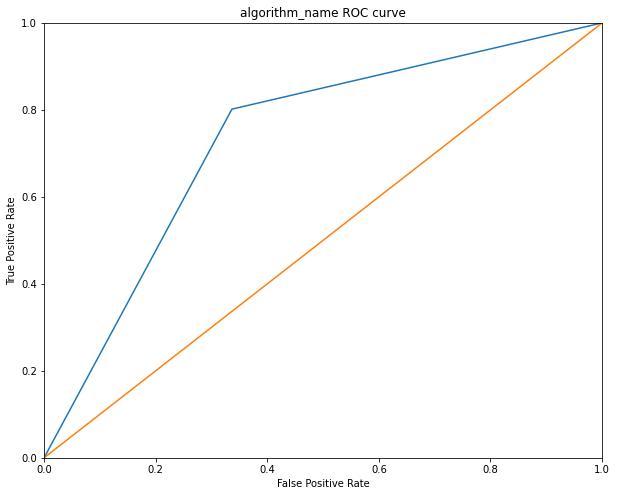

In [ ]:
# SVC
algorithm(SVC)

# 나머지 모델 저장

In [ ]:
import joblib
joblib.dump(BernoulliNB,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/BernoulliNB_Model.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/BernoulliNB_Model.pkl']

In [ ]:
import joblib

joblib.dump(KNeighborsClassifier,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/KNeighborsClassifier.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/KNeighborsClassifier.pkl']

In [ ]:
AdaBoostClassifier
import joblib

joblib.dump(AdaBoostClassifier,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/AdaBoostClassifier.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/AdaBoostClassifier.pkl']

In [ ]:
import joblib

joblib.dump(SGDClassifier,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/SGDClassifier_re.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/SGDClassifier_re.pkl']

In [ ]:
import joblib

joblib.dump(XGBClassifier,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/XGBClassifier.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/XGBClassifier.pkl']

In [ ]:
import joblib

joblib.dump(LGBMClassifier,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/LGBMClassifier.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/LGBMClassifier.pkl']

In [ ]:
import joblib

joblib.dump(SVC,'/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/SVC_re.pkl')

['/content/drive/MyDrive/한국품질재단/2차 미니프로젝트/model/SVC_re.pkl']